# Object Detection on TACO Trash Dataset

# Outline

## The Final Report contains the following components:


#### 1. Background
    - Objective
    - Motivation

#### 2. Dataset
    - Dataset description
    - Class distribution

#### 3. Faster RCNN


#### 4. DETR Detection Transformer


#### 5. Yolo v5 (S, M, L)


#### 6. Yolo v7 (S, M, L)


#### 7. Object Detection from Scratch


#### 8. Discussion on the overall results


#### 9. References





# 1. Background: 

### **Goal**: 
Our goal is to perform object detection on Trash objects. 

### **Motivation**: 
Scheduling litter pickup and cleaning of steets are currently done by staff members working for cities. This process is time consuming since staff members need to look for trash by manually inspecting each street. The procees takes from several days to even a month. If we could automate litter detction, in future we can incorporate this feature into robots and have robots clean up the streets instead. This would not only speed up the process but would also relieve staff member of the tedious work.



# 2. **Dataset:** 

### Dataset Description
We plan to use the TACO dataset since it a dataset specifically created to peform trash detection and has the largest collection of trash images with about 60 different classes (types of trash). We obtain the datset from the following github repository:  
https://github.com/pedropro/TACO


![TACO Dataset](https://drive.google.com/uc?id=1_j4sSxawSkSJM_qth2xCP2GZeCkOgDiO)



### Class Distribution

We have in total of 60 classes of trash, the data is imbalanced and some minority class only have less than 10 samples.


![class imabalnce](https://drive.google.com/uc?id=11iCLBj7GNR3BYC1z2p7M2pmhCrc1mFjG)

# 3. Faster RCNN

note: the subtitle need to be consistent

# 4. DETR Detection Transformer

# 5. Yolo v5 (S, M, L)

# 6. Yolo v7 (S, M, L)

# 7. Object Detection from Scratch

# Part A: Creating Trash Detection from Scratch

# Load the TACO dataset

The TACO dataset was first downloaded to local machine using the githib repository: https://github.com/pedropro/TACO . This dataset folder has 15 other folders containing TACO trash images and had all class labels in one annotaions.json file.

In order to load the dataset we need to convert it into Pascal VOC XML format where one folder will contain all images in .jpg format and another folder will contain all corresponding .xml file annotions for each image. We do this conversion using Robolfow solftware. Now our dataset folder has the follwing directory stucture:

Folder format:
- **dataset**
  - **annot**: contains .xml files for all images
  - **images**: contains .jpg files for all images


We then import dataset folder into our google drive.

At first we start importing libraries including pandas, CSV, and XML which will help us work on the inputs.

In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image

import pandas as pd
from xml.dom import minidom
import csv

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Specify the subset of classes and their labels

Initially we used all 60 classes however, our model wasn't performaing very well. Hence we only picked classes with sufficient number of images. As you can see we only choose the top 21 classes having the most number of images.

In [ ]:

# Remove extra under represented classes from dictionary
labels_to_num = {'Aluminium foil': 0,
             'Broken glass': 1,
             'Cigarette': 2,
             'Clear plastic bottle': 3,
             'Corrugated carton': 4,
             'Disposable plastic cup': 5,
             'Drink can': 6,
             'Glass bottle': 7,
             'Metal bottle cap': 8,
             'Normal paper': 9,
             'Other carton': 10,
             'Other plastic': 11,
             'Other plastic wrapper':12,
             'Paper cup': 13,
             'Plastic bottle cap': 14,
             'Plastic film': 15,
             'Plastic lid': 16,
             'Plastic straw':17,
             'Pop tab': 18,
             'Single-use carrier bag': 19,
             'Styrofoam piece': 20}


In [ ]:
num_to_labels = dict((v,k) for k,v in labels_to_num.items())

In [ ]:
num_to_labels

{0: 'Aluminium foil',
 1: 'Broken glass',
 2: 'Cigarette',
 3: 'Clear plastic bottle',
 4: 'Corrugated carton',
 5: 'Disposable plastic cup',
 6: 'Drink can',
 7: 'Glass bottle',
 8: 'Metal bottle cap',
 9: 'Normal paper',
 10: 'Other carton',
 11: 'Other plastic',
 12: 'Other plastic wrapper',
 13: 'Paper cup',
 14: 'Plastic bottle cap',
 15: 'Plastic film',
 16: 'Plastic lid',
 17: 'Plastic straw',
 18: 'Pop tab',
 19: 'Single-use carrier bag',
 20: 'Styrofoam piece'}

# Retrive the bounding box info and classes for each image using their file path

In [ ]:
# This function reads the xml annotation file for each image and gets theri bounding box co-ordinates and labels
def extract_xml_contents(annot_directory, image_dir):

        #print(annot_directory)
        
        file = minidom.parse(annot_directory)

        # Get the height and width for our image
        height, width = cv2.imread(image_dir).shape[:2]

        # Get the bounding box co-ordinates 
        
        xmin = file.getElementsByTagName('xmin')
        x1 = float(xmin[0].firstChild.data)

        ymin = file.getElementsByTagName('ymin')
        y1 = float(ymin[0].firstChild.data)

        xmax = file.getElementsByTagName('xmax')
        x2 = float(xmax[0].firstChild.data)

        ymax = file.getElementsByTagName('ymax')
        y2 = float(ymax[0].firstChild.data)

        class_name = file.getElementsByTagName('name')

        class_name_val= class_name[0].firstChild.data
        class_num= labels_to_num[class_name_val]

        files = file.getElementsByTagName('filename')
        filename = files[0].firstChild.data

        # Return the extracted attributes
        return filename,  width, height, class_num, x1,y1,x2,y2

In [ ]:
# This functions stores the image name, bounding box co-oredinates, widht and height of image, and class label to a csv file. This is to store for future use.
# Function to convert XML files to CSV
def xml_to_csv():

  # List containing all our attributes regarding each image
  xml_list = []

  # We loop our each class and its labels one by one to preprocess and augment 
  image_dir = '/content/drive/MyDrive/MIE1517Project/datasetsmall/images/'
  annot_dir = '/content/drive/MyDrive/MIE1517Project/datasetsmall/annot'

  # Get each file in the image and annotation directory
  mat_files = os.listdir(annot_dir)
  img_files = os.listdir(image_dir)

  # Loop over each of the image and its label
  #i=0
  for mat, image_file in zip(mat_files, img_files):
      #i=i+1
      #print(i)

      #print(mat)
      #print(image_file)
      
      # Full mat path
      mat_path = os.path.join(annot_dir, mat)
      

      # Full path Image
      img_path = os.path.join(image_dir, image_file)

      # Get Attributes for each image 
      value = extract_xml_contents(mat_path, img_path)

      # Append the attributes to the mat_list
      xml_list.append(value)

  # Columns for Pandas DataFrame
  column_name = ['filename', 'width', 'height', 'class_num', 'xmin', 'ymin', 
                 'xmax', 'ymax']

  # Create the DataFrame from mat_list
  xml_df = pd.DataFrame(xml_list, columns=column_name)

  # Return the dataframe
  return xml_df

# The Classes we will use for our training # Not used 
#classes_list = sorted(['Aluminium foil', 'Cigarette', 'Clear plastic bottle', 'Corrugated carton', 'Crisp packet', 'Disposable food container', 'Disposable plastic cup', 'Drink can', 'Drink carton', 'Glass bottle', 'Metal bottle cap', 'Normal paper', 'Other carton', 'Other plastic', 'Other plastic bottle', 'Other plastic wrapper', 'Paper cup'])

# Run the function to convert all the xml files to a Pandas DataFrame
labels_df = xml_to_csv()

# Saving the Pandas DataFrame as CSV File
labels_df.to_csv(('dataset.csv'), index=None)

In [ ]:
# Our dataset images are of size 416
image_size= 416

In [ ]:
# This retrives the labels, bounding box info and img pixel arrray. It loads the data into the returned variables 
def preprocess_dataset():
  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []

  h = image_size
  w = image_size
  image_dir = '/content/drive/MyDrive/MIE1517Project/datasetsmall/images/'

  with open('dataset.csv') as csvfile:
      rows = csv.reader(csvfile)
      columns = next(iter(rows))
      for row in rows:
        labels.append(int(row[3]))
        #Scaling Coordinates to the range of [0,1] by dividing the coordinate with image size, 256 here.
        arr = [float(row[4])/image_size,  
               float(row[5])/image_size,
               float(row[6])/image_size,
               float(row[7])/image_size]
        boxes.append(arr)
        img_path = row[0]
        # Read the image
        img  = cv2.imread(os.path.join(image_dir,img_path))

        # Resize all images to a fix size
        #print(img_path)
        image = cv2.resize(img, (image_size, image_size))

        # # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize the image by dividing it by 255.0 
        image = image.astype("float") / 255.0

        # Append it to the list of images
        img_list.append(image)

  return labels, boxes, img_list

In [ ]:
# All images will resized to 416, 416 
#image_size = image_size

# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset()

# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, labels))
random.shuffle(combined_list)

# Extract back the contents of each list
img_list, boxes, labels = zip(*combined_list)

In [ ]:
len(img_list)

1343

In [ ]:
len(boxes)

1343

In [ ]:
len(labels)

1343

# Plot images and bounding boxes to visualize TACO dataset

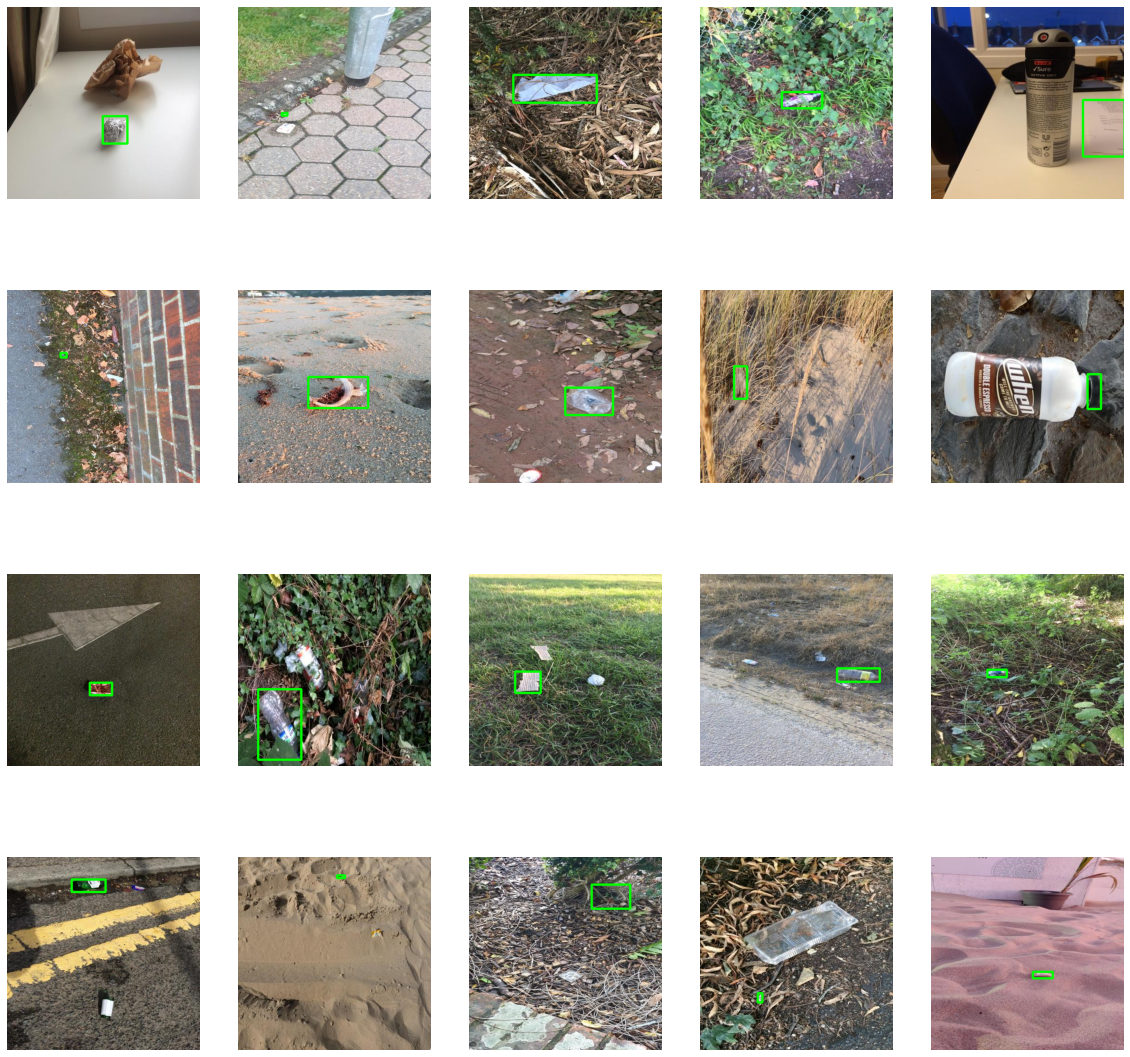

In [ ]:
from matplotlib import pyplot as plt
import cv2


# Create a Matplotlib figure
plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 20)


for itr, i in enumerate(random_range, 1):
  # Bounding box of each image
  a1, b1, a2, b2 = boxes[i];
  img_size = image_size

  # Rescaling the boundig box values to match the image size
  x1 = a1 * img_size
  x2 = a2 * img_size
  y1 = b1 * img_size
  y2 = b2 * img_size

  # The image to visualize
  image = img_list[i]

  # Draw bounding boxes on the image
  cv2.rectangle(image, (int(x1),int(y1)) , (int(x2),int(y2)) , (0,255,0), 3);

  # Clip the values to 0-1 and draw the sample of images
  img = np.clip(img_list[i], 0, 1)
  plt.subplot(4, 5, itr);
  plt.imshow(img);
  plt.axis('off');

# Split Dataset into Train, Validation, and Test sets

In [ ]:
# Initially split data into 80% train set and keep remiang 20% for test and validation
train_images, rest_images, train_labels, rest_labels, train_boxes, rest_boxes = train_test_split( np.array(img_list), 
                np.array(labels), np.array(boxes), test_size = 0.2, 
                random_state = 43)

print('Training Images Count: {}, Remaining Images Count: {}'.format(
    len(train_images), len(rest_images) ))

Training Images Count: 1074, Remaining Images Count: 269


In [ ]:
# Then split the reaming 20% into 50% to get 10% val and test data
val_images, test_images, val_labels, test_labels, val_boxes, test_boxes = train_test_split( np.array(rest_images), 
                np.array(rest_labels), np.array(rest_boxes), test_size = 0.5, 
                random_state = 43)

print('Validation Images Count: {}, Test Images Count: {}'.format(
    len(val_images), len(test_images) ))

Validation Images Count: 134, Test Images Count: 135


In [ ]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle
import random
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#Fucntion to convert numpy arrays to torch
class Dataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = torch.permute(torch.from_numpy(train_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()

    def __len__(self):
        return len(self.labels)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])

# Inheriting from Dataset class

class ValDataset(Dataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = torch.permute(torch.from_numpy(val_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()

In [ ]:
# Convert numpy arrays to torch
dataset = Dataset(train_images, train_labels, train_boxes)
valdataset = ValDataset(val_images, val_labels, val_boxes)
testdataset= ValDataset(test_images, test_labels, test_boxes)

# Define Neural Network Architecture

Since our image size if 416x416 I used 6 convolutional layers, kernel size of 3 and 5 and max pool layers of 2x2 to represent the images as 5x5 dimension embedddings with 192 different feature maps.

Then I created two different multi layer perceptron (MLP). One for classification into one of the 21 classes (has 21 output nodes) and one for determining the four bounding boxes (4 output nodes).

I used relu activation since it is the most popular and also helps combat the vanishing and exploding gradient problem.

For classification I'm using nn.CrossEntropyLoss function with built in soft max and so I did not use softmax activation in my last classification layer.

For bounding box prediction I use nn.MSELoss and so I applied sigmoid activation to my last layer.

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)  # in= 416--> 414--> pool--> 207
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3) # 207--> 205 -->pool--> 102.5 ~102
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3) # 102--> 100 --> pool --> 50
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5) # 50--> 46 --> pool --> 23
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5) # 23--> 19 --> pool--> 9.5~ 9
        self.conv6 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=5) # 9 -->5    flattened--> 5*5*192=4800


        # Connecting CNN outputs with Fully Connected layers for classification
        self.class_fc1 = nn.Linear(in_features=4800, out_features=1200)
        self.class_fc2 = nn.Linear(in_features=1200, out_features=300)
        self.class_fc3 = nn.Linear(in_features=300, out_features=75)
        self.class_out = nn.Linear(in_features=75, out_features=21) # 21 classes

        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.box_fc1 = nn.Linear(in_features=4800, out_features=1200)
        self.box_fc2 = nn.Linear(in_features=1200, out_features=300)
        self.box_fc3 = nn.Linear(in_features=300, out_features=75)
        self.box_out = nn.Linear(in_features=75, out_features=4)


    def forward(self, t):

        # Image Classification Forward Feed
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)

        t = self.conv6(t)
        t = F.relu(t)

        t = torch.flatten(t,start_dim=1)
        

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = self.class_fc3(class_t)
        class_t = F.relu(class_t)

        class_t = self.class_out(class_t)  # no need softmax since using cross entropy loss with softmax
        class_t = class_t.squeeze(1)

        # Bounding Box Forward Feed

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_fc3(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = torch.sigmoid(box_t) # Need to apply sihmoid since using MSELoss
        

        return [class_t,box_t]

In [ ]:
model = Network()
model = model.to(device)
model

Network(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1))
  (class_fc1): Linear(in_features=4800, out_features=1200, bias=True)
  (class_fc2): Linear(in_features=1200, out_features=300, bias=True)
  (class_fc3): Linear(in_features=300, out_features=75, bias=True)
  (class_out): Linear(in_features=75, out_features=21, bias=True)
  (box_fc1): Linear(in_features=4800, out_features=1200, bias=True)
  (box_fc2): Linear(in_features=1200, out_features=300, bias=True)
  (box_fc3): Linear(in_features=300, out_features=75, bias=True)
  (box_out): Linear(in_features=75, out_features=4, bias=True)
)

# Traning Code for CNN model

In [ ]:
# Function to get accuracy
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [ ]:
def get_main_model_name(name, batch_size, learning_rate, epoch):
  
    path = "main_model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
# This accuracy fucntion computes missiclassification error rate (for classification problems)
def get_accuracy(model, t_loader, v_loader, train=True):  #takes in train_loader abd val_loader
  
    if train:
        data_loader = t_loader
    else:
        data_loader = v_loader

    correct = 0
    total = 0
    for imgs, labels, boxes in data_loader:
        
        #imgs = alexNet.features(imgs) #SLOW
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          boxes = boxes.cuda()
        #############################################
        
        
        [y_pred,z_pred] = model(imgs)
        
        #select index with maximum prediction score
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, t_data, v_data, batch_size=100, num_epochs=1, learning_rate=0.001): 


    num_workers=0

    train_loader = torch.utils.data.DataLoader(t_data, batch_size=batch_size,num_workers= num_workers,  shuffle=True)
    val_loader = torch.utils.data.DataLoader(v_data, batch_size=batch_size, num_workers= num_workers,  shuffle=True)


    criterion = nn.CrossEntropyLoss()
    criterion2= nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []



    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels, boxes in iter(train_loader):
          

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              boxes= boxes.cuda()
            #############################################
            
            
            [y_pred,z_pred]= model(imgs)
            loss1 = criterion(y_pred, labels) # compute the total loss
            loss2= criterion2(z_pred, boxes)
            loss = loss1 + loss2
            
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            loss_real= float(loss)/batch_size
            losses.append(loss_real)             # compute *average* loss
            t_acc= get_accuracy(model, train_loader, val_loader,  train=True)
            train_acc.append(t_acc) # compute training accuracy 

            v_acc= get_accuracy(model, train_loader, val_loader, train=False)
            val_acc.append(v_acc)  # compute validation accuracy
            n += 1

            print("Iter", n, "Train Accuracy", t_acc, "Validation Accuracy", v_acc, "loss:",loss_real)

            # Save the current model (checkpoint) to a file
            #model_path = get_main_model_name("TrashDetector", batch_size, learning_rate, epoch)
            #torch.save(model.state_dict(), model_path)


    end_time = time.time()
    elapsed_time = end_time - start_time


    


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

'''
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_losses.csv".format(model_path), losses)
'''


'\n    # Write the train/test loss/err into CSV file for plotting later\n    epochs = np.arange(1, num_epochs + 1)\n    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)\n    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)\n    np.savetxt("{}_losses.csv".format(model_path), losses)\n'

CUDA is available!  Training on GPU ...
Iter 1 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09612078219652176
Iter 2 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09611675888299942
Iter 3 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09617751836776733
Iter 4 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09595724195241928
Iter 5 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09651315212249756
Iter 6 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09666895121335983
Iter 7 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09535454213619232
Iter 8 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss: 0.09658244997262955
Iter 9 Train Accuracy 0.049348230912476726 Validation Accuracy 0.09701492537313433 loss:

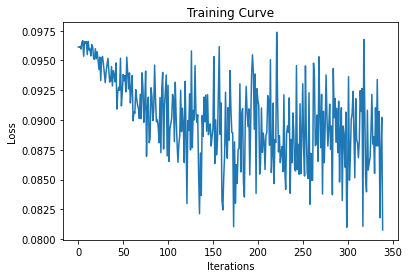

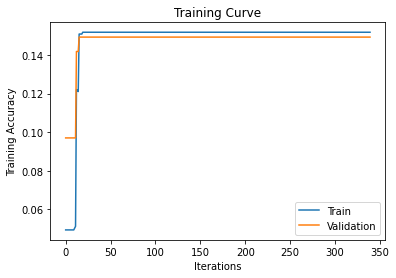

Final Training Accuracy: 0.15176908752327747
Final Validation Accuracy: 0.14925373134328357
Total time elapsed: 590.91 seconds


In [ ]:
use_cuda = True

main_model =  Network()

if use_cuda and torch.cuda.is_available():
  main_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
# Traning on given dataset 
train(main_model, dataset, valdataset, batch_size=32, num_epochs=10, learning_rate=0.01)

CUDA is available!  Training on GPU ...
Iter 1 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.03077965497970581
Iter 2 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.03075694799423218
Iter 3 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.0305806303024292
Iter 4 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.030890953540802003
Iter 5 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.03077101707458496
Iter 6 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.03077571392059326
Iter 7 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.030600812435150147
Iter 8 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.030699594020843504
Iter 9 Train Accuracy 0.08007448789571694 Validation Accuracy 0.07462686567164178 loss: 0.0307

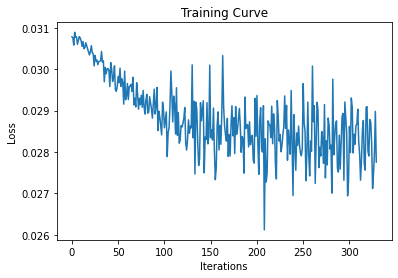

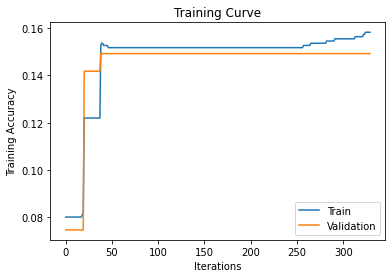

Final Training Accuracy: 0.15828677839851024
Final Validation Accuracy: 0.14925373134328357
Total time elapsed: 617.36 seconds


In [ ]:
use_cuda = True

main_model =  Network()

if use_cuda and torch.cuda.is_available():
  main_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
# Traning on given dataset 
train(main_model, dataset, valdataset, batch_size=100, num_epochs=30, learning_rate=0.01)

CUDA is available!  Training on GPU ...
Iter 1 Train Accuracy 0.05307262569832402 Validation Accuracy 0.029850746268656716 loss: 0.030841245651245117
Iter 2 Train Accuracy 0.05307262569832402 Validation Accuracy 0.029850746268656716 loss: 0.03088651180267334
Iter 3 Train Accuracy 0.05307262569832402 Validation Accuracy 0.029850746268656716 loss: 0.030794718265533448
Iter 4 Train Accuracy 0.054003724394785846 Validation Accuracy 0.029850746268656716 loss: 0.03084212779998779
Iter 5 Train Accuracy 0.15176908752327747 Validation Accuracy 0.14925373134328357 loss: 0.030732150077819823
Iter 6 Train Accuracy 0.15176908752327747 Validation Accuracy 0.14925373134328357 loss: 0.030408966541290283
Iter 7 Train Accuracy 0.15176908752327747 Validation Accuracy 0.14925373134328357 loss: 0.030592060089111327
Iter 8 Train Accuracy 0.15176908752327747 Validation Accuracy 0.14925373134328357 loss: 0.030298583507537842
Iter 9 Train Accuracy 0.15176908752327747 Validation Accuracy 0.14925373134328357 los

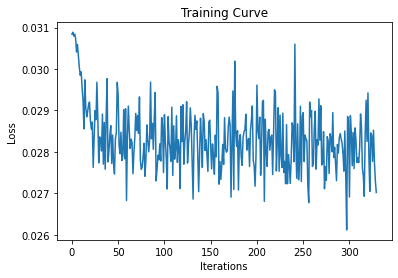

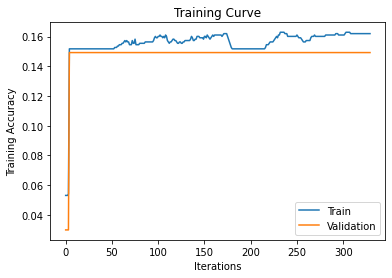

Final Training Accuracy: 0.16201117318435754
Final Validation Accuracy: 0.14925373134328357
Total time elapsed: 631.36 seconds


In [ ]:
use_cuda = True

main_model =  Network()

if use_cuda and torch.cuda.is_available():
  main_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
# Traning on given dataset 
train(main_model, dataset, valdataset, batch_size=100, num_epochs=30, learning_rate=0.1)

In [ ]:
torch.save(main_model.state_dict(), "/content/main_model.pth")

**AlexNet Implementation:**

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Artifical Neural Network Architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(256 * 12 * 12, 4000)
        self.fc2 = nn.Linear(4000, 400)
        self.fc3 = nn.Linear(400, 21)

        self.box_fc1 = nn.Linear(256 * 12 * 12, 4000)
        self.box_fc2 = nn.Linear(4000, 400)
        self.box_fc3 = nn.Linear(400, 4)

    def forward(self, x):
        #x = x.view(-1, 256 * 12 * 12) #flatten feature data
        x = x.reshape(-1, 256 * 12 * 12)

        class_t = F.relu(self.fc1(x))
        class_t = F.relu(self.fc2(class_t))
        class_t = self.fc3(class_t)


        box_t = self.box_fc1(x)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_fc3(box_t)
        box_t = F.sigmoid(box_t)
        return [class_t,box_t]



In [ ]:
model2 = MLP()
model2 = model2.to(device)
model2

MLP(
  (fc1): Linear(in_features=36864, out_features=4000, bias=True)
  (fc2): Linear(in_features=4000, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=21, bias=True)
  (box_fc1): Linear(in_features=36864, out_features=4000, bias=True)
  (box_fc2): Linear(in_features=4000, out_features=400, bias=True)
  (box_fc3): Linear(in_features=400, out_features=4, bias=True)
)

In [ ]:
# This accuracy fucntion computes missiclassification error rate (for classification problems)
def get_accuracy(model, t_loader, v_loader, train=True):  #takes in train_loader abd val_loader
  
    if train:
        data_loader = t_loader
    else:
        data_loader = v_loader

    correct = 0
    total = 0
    for imgs, labels, boxes in data_loader:
        
        imgs = alexnet.features(imgs) #SLOW
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          boxes = boxes.cuda()
        #############################################
        
        
        [y_pred,z_pred] = model(imgs)
        
        #select index with maximum prediction score
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, t_data, v_data, batch_size=100, num_epochs=1, learning_rate=0.001): #train_data, validation_data
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

    num_workers=0

    train_loader = torch.utils.data.DataLoader(t_data, batch_size=batch_size,num_workers= num_workers,  shuffle=True)
    val_loader = torch.utils.data.DataLoader(v_data, batch_size=batch_size, num_workers= num_workers,  shuffle=True)


    criterion = nn.CrossEntropyLoss()
    criterion2= nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []



    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels, boxes in iter(train_loader):
          
            #imgs = features = alexNet.features(imgs) #SLOW
            #print(n)

            imgs = alexnet.features(imgs) #SLOW
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              boxes= boxes.cuda()
            #############################################
            
            
            [y_pred,z_pred]= model(imgs)
            loss1 = criterion(y_pred, labels) # compute the total loss
            loss2= criterion2(z_pred, boxes)
            loss = loss1 + loss2
            
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            loss_real= float(loss)/batch_size
            losses.append(loss_real)             # compute *average* loss
            t_acc= get_accuracy(model, train_loader, val_loader,  train=True)
            train_acc.append(t_acc) # compute training accuracy 

            v_acc= get_accuracy(model, train_loader, val_loader, train=False)
            val_acc.append(v_acc)  # compute validation accuracy
            n += 1

            print("Iter", n, "Train Accuracy", t_acc, "Validation Accuracy", v_acc, "loss:",loss_real)

            # Save the current model (checkpoint) to a file
            #model_path = get_main_model_name("TrashDetector", batch_size, learning_rate, epoch)
            #torch.save(model.state_dict(), model_path)


    end_time = time.time()
    elapsed_time = end_time - start_time


    


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

'''
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_losses.csv".format(model_path), losses)
'''


'\n    # Write the train/test loss/err into CSV file for plotting later\n    epochs = np.arange(1, num_epochs + 1)\n    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)\n    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)\n    np.savetxt("{}_losses.csv".format(model_path), losses)\n'

CUDA is available!  Training on GPU ...
Iter 1 Train Accuracy 0.13966480446927373 Validation Accuracy 0.14925373134328357 loss: 0.030755455493927
Iter 2 Train Accuracy 0.15083798882681565 Validation Accuracy 0.16417910447761194 loss: 0.030618817806243898
Iter 3 Train Accuracy 0.148975791433892 Validation Accuracy 0.17164179104477612 loss: 0.030056231021881104
Iter 4 Train Accuracy 0.14804469273743018 Validation Accuracy 0.17164179104477612 loss: 0.029376416206359862
Iter 5 Train Accuracy 0.14804469273743018 Validation Accuracy 0.17164179104477612 loss: 0.028664405345916747
Iter 6 Train Accuracy 0.14804469273743018 Validation Accuracy 0.17164179104477612 loss: 0.02867465019226074
Iter 7 Train Accuracy 0.14804469273743018 Validation Accuracy 0.17164179104477612 loss: 0.029791650772094728
Iter 8 Train Accuracy 0.21042830540037244 Validation Accuracy 0.17164179104477612 loss: 0.028584251403808592
Iter 9 Train Accuracy 0.1303538175046555 Validation Accuracy 0.11194029850746269 loss: 0.02931

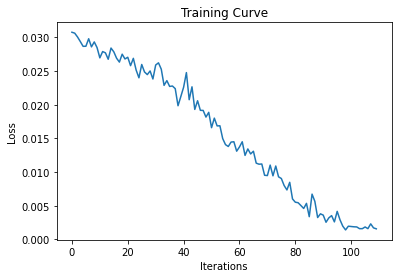

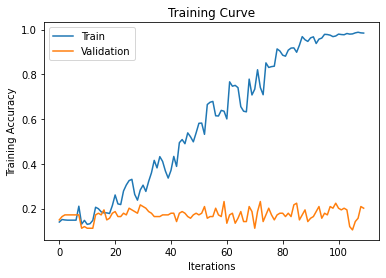

Final Training Accuracy: 0.984171322160149
Final Validation Accuracy: 0.20149253731343283
Total time elapsed: 6296.87 seconds


In [ ]:
use_cuda = True

alexnet_model =  MLP()

if use_cuda and torch.cuda.is_available():
  alexnet_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
# Traning on given dataset 
train(alexnet_model, dataset, valdataset, batch_size=100, num_epochs=10, learning_rate=0.01)

In [ ]:
# Save the current model (checkpoint) to a file
model_path = get_main_model_name("alexnet_model", 100, 0.01, 10)
torch.save(alexnet_model.state_dict(), model_path)


# Model Testing and Evaluation

In [ ]:
image_size=416

In [ ]:
# Ensure test images are resized to 416 *416 and normalize pixels
def preprocess(img, image_size = image_size):
    
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expand dimensions as predict expect image in batches
    image = np.expand_dims(image, axis=0) 
    return image

In [ ]:
# Functions gets class and bounding box preds  
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    [class_probs, bounding_box] = results

    # First let's get the class label

    # The index of class with the highest confidence is our target class
    class_index = torch.argmax(class_probs)
  
    # Use this index to get the class name.
    class_label = num_to_labels[int(class_index.item())] # new

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = image_size,image_size

    # Extract the Coordinates
    x1, y1, x2, y2 = bounding_box[0]

    # # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    # return the lable and coordinates
    return class_label, (x1,y1,x2,y2), torch.max(class_probs)*100

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

# alexnet
import torchvision.models

torch.manual_seed(1) # set the random seed
alexNet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# We will use this function to make prediction on images.
def predict(image,  scale = 0.5):
  
  model =  MLP()
  model = model.to(device)
  model.load_state_dict(torch.load("/content/main_model_alexnet_model_bs100_lr0.01_epoch10")) # Need to load desired model
  model.eval()
  
  # Reading Image
  img  = cv2.imread(image)
  
  # # Before we can make a prediction we need to preprocess the image.
  processed_image = preprocess(img)

  torch_img= torch.permute(torch.from_numpy(processed_image).float(),(0,3,1,2))
  
  # Convert to alexnet features
  img_feature = alexNet.features(torch_img) # pass images into alexnet feature map to extract new features

  result = model(img_feature.to(device))

  # After postprocessing, we can easily use our results
  label, (x1, y1, x2, y2), confidence = postprocess(image, result)

  # Now annotate the image
  cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText(
      img, 
      '{}, CONFIDENCE: {}'.format(label, confidence), 
      (30, int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (200, 55, 100),
      2
      )

  # Show the Image with matplotlib
  plt.figure(figsize=(10,10))
  plt.imshow(img[:,:,::-1])


In [ ]:
# Pass image to test
img_path_test='/content/drive/MyDrive/MIE1517Project/datasetsmall/images/000000_JPG.rf.0c5ced8ada28f52a2df8833d2284a7c8.jpg'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


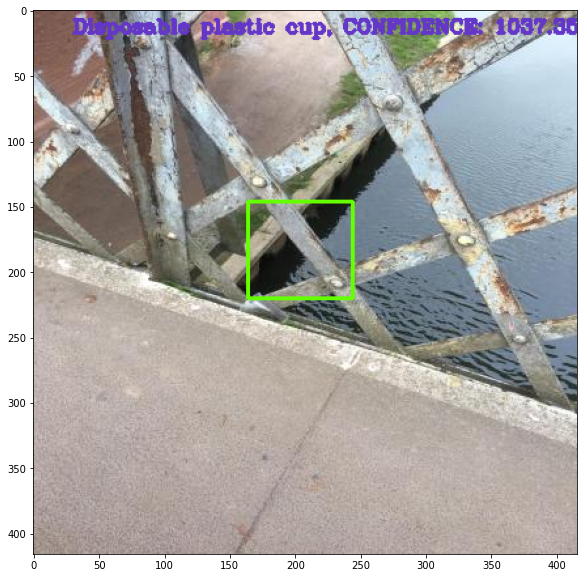

In [ ]:
#image = img_path_test
predict(img_path_test)

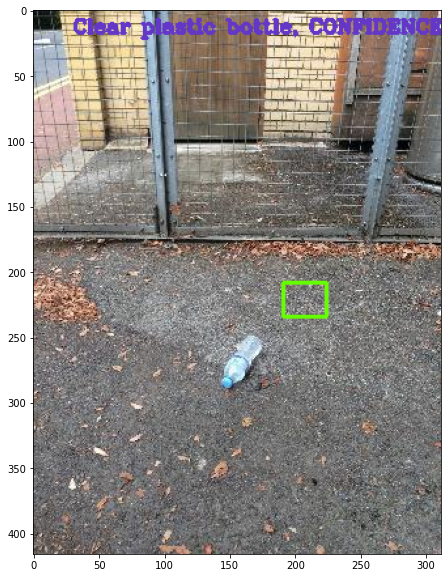

In [ ]:
img2='/content/drive/MyDrive/MIE1517Project2/datasetsmall/images/000000_jpg.rf.02f07144cb4d0d247a6522668ac6e8e9.jpg'
predict(img2)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


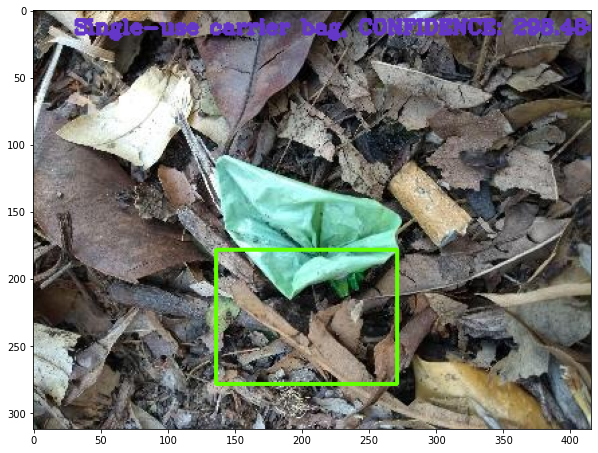

In [ ]:
img3= '/content/drive/MyDrive/MIE1517Project2/datasetsmall/images/000003_jpg.rf.942d72ee408710001b2a0af3720be44a.jpg'
predict(img3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


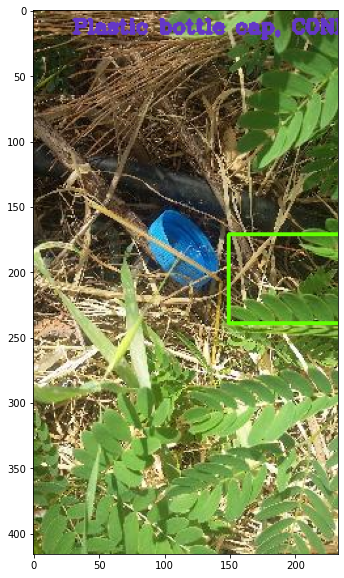

In [ ]:
img4= '/content/drive/MyDrive/MIE1517Project2/datasetsmall/images/000006_jpg.rf.7a04ec1e1239437bb0bda8a5272a3f6c.jpg'
predict(img4)

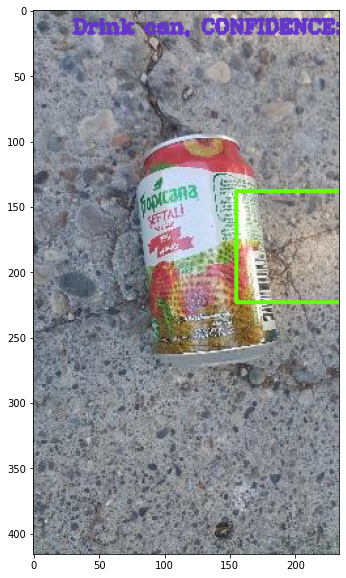

In [ ]:
img5= '/content/drive/MyDrive/MIE1517Project2/datasetsmall/images/000008_jpg.rf.70dcd82bc3c0b1f06a8da61ce3a542f3.jpg'
predict(img5)

In [ ]:
# Passing another image
img_path_test="/content/drive/MyDrive/MIE1517Project2/datasetsmall/images/000008_jpg.rf.8209acb78204b4d28ef82ea7655dc92d.jpg"

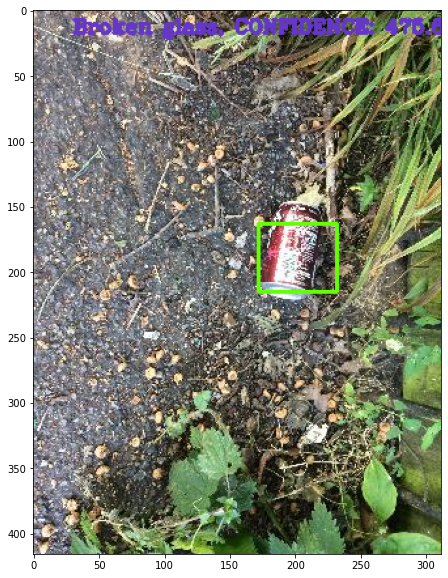

In [ ]:
image = img_path_test
predict(image)

Get accuracy on test set

In [ ]:
def evaluate1(model, test_loader):
       
    data_loader = test_loader

    correct = 0
    total = 0
    for imgs, labels, boxes in data_loader:

        imgs = alexnet.features(imgs) #SLOW
        
        # Tensors don't match if we execute this
        ############################################# 
        #To Enable GPU Usage
        #if use_cuda and torch.cuda.is_available():
          #imgs = imgs.cuda()
          #labels = labels.cuda()
          #boxes = boxes.cuda()
        #############################################
        
        
        [y_pred,z_pred] = model(imgs)
        
        #select index with maximum prediction score
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=100, 
                                          num_workers=0, shuffle=True)

In [ ]:
net = MLP()
state = torch.load('/content/main_model_alexnet_model_bs100_lr0.01_epoch10')
net.load_state_dict(state)

<All keys matched successfully>

In [ ]:
Test_accuracy= evaluate1(net, test_loader)
print("Accuracy: " + str(Test_accuracy))

Accuracy: 0.15555555555555556


# Comments for Part A:

We can see our model prediction for the classes is good after converting our images to Alexnet features, however the bounding boxes are not predicted well. This could be because Alexnet was not desinged to peform object localization but rather image classification. I think models like faster RCNN models would be more capable of predicting the bounding boxes correctly since it has trained region proposal networks. 

Now we'll try out other architucteure such as YOLO and transformer model to compare see if we can improve the performance.



# 2nd Apporach: Using YOLO to retrive pre-tained model weights traine don COCO dataset
The TACO dataset is similar to COCO dataset and so this should improve the detection alot.

In [ ]:
%%shell
jupyter nbconvert --to html MIE1517_GroupProject.ipynb

[NbConvertApp] Converting notebook MIE1517_GroupProject.ipynb to html
/usr/local/lib/python3.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 4186873 bytes to MIE1517_GroupProject.html


# 8. Discussion on overall Results:

### Discussion on model's results

Here we present the results of trained object detection model in this project. The model with best performance is Faster RCNN reach mAP 16.7%, which is comparable with TACO dataset’s author’s experiment results, they reached mAP around 17.6%. Also we did a sanity check to determine  if we setup the model correctly, both yolo and DETR were able to reach high mAP on other Dataset.

The trend in the results have shown that as the model weights increase in yolo models, the mAP tend to improve, however two stage model Faster RCNN outperformed the yolo models.
And the transformer Based model DETR has a moderate level of detection performance, this is due to the limited computational power available to us, after 4 hours of training, the model’s mAP is continually increasing, however team stopped to train model with more epoches, as the purpose of this project is to learn how to implement these models.


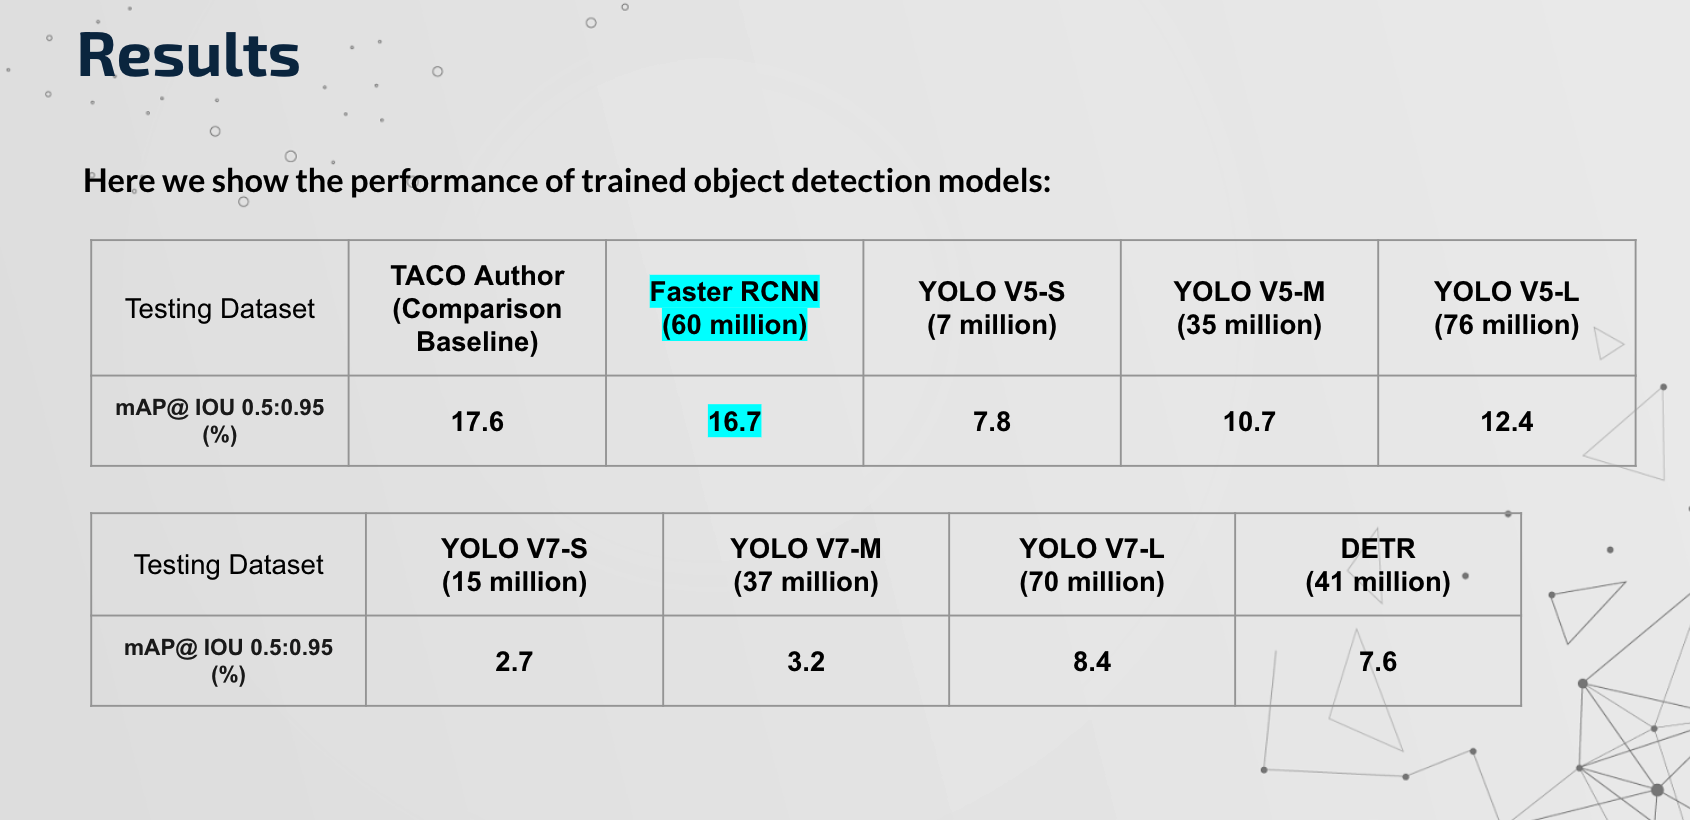

In [4]:
# Imports PIL module 
from PIL import Image
import os

cwd=os.getcwd()
  
# open method used to open different extension image file
im = Image.open(cwd+"/"+"1.png") 
  
# This method will show image in any image viewer 
display(im)

### Problem with detecting small objects

Here, we show the performance of Faster RCNN on different size of objects (in terms of its size in image):, as can be observed in the chart, the model performs well when the object occupy large proportion of image, but does not well with small objects.
This is verified with the bottom two pictures, where the model was able to make good detection on large bottles, but the model failed to make correct detection small garbages.
Moving forward, it would be beneficially to train object detection model separately on different size of object, to achieve a better detection performance.


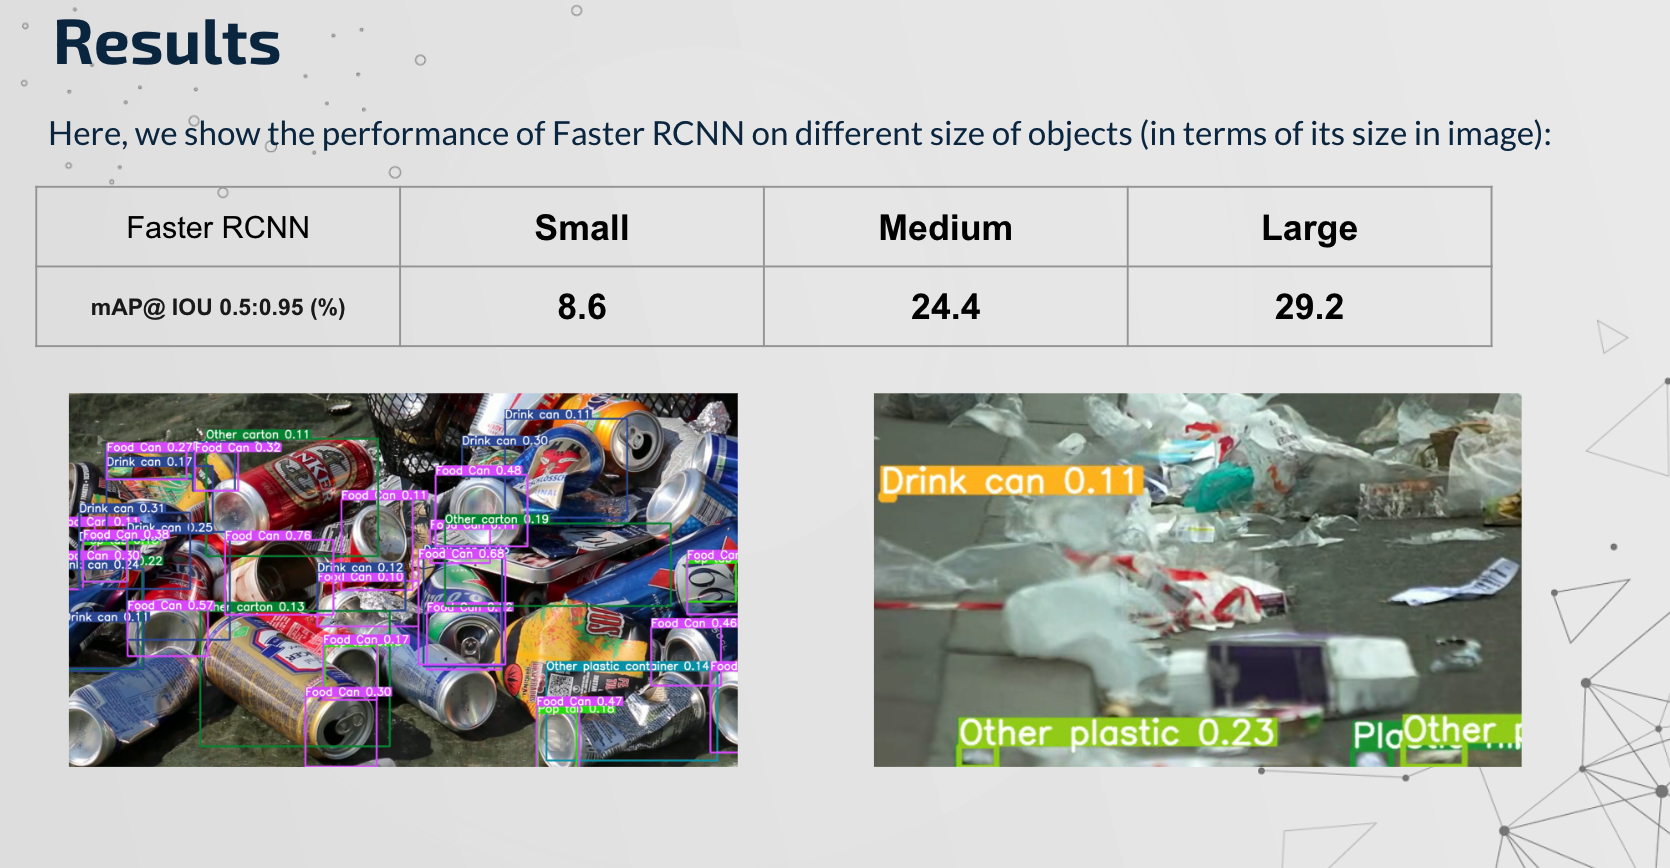

In [6]:
# Imports PIL module 
from PIL import Image
import os

cwd=os.getcwd()
  
# open method used to open different extension image file
im = Image.open(cwd+"/"+"3.png") 
  
# This method will show image in any image viewer 
display(im)

### Video Demonstration:

We have inferenced video with Faster RCNN and detection transformer models on new unseen test data. The link to the videos are shown here.

 - https://drive.google.com/file/d/1drvXzB0zKbAfjMaYIfhFIYFsqvbefb9e/view?resourcekey
 - https://drive.google.com/file/d/1drvXzB0zKbAfjMaYIfhFIYFsqvbefb9e/view?resourcekey
 



The Bboxes with the corresponding trash classification highlight all the detected trash in every frame. The faster RCNN model trained on Taco data can detect most of food and drink cans in the first video, while there are more kinds of trash in the second video, the transformer-based model can also detect most of the trash. Since the transformer model was trained on the dataset with only two labels, trash or not to facilitate training. The model only performs binary classification here.
But the two models suffer from a low confidence on classification, and the IoU and accuracy of the Bbox are a bit low.



### Challenges encountered in this project

We had several challenges working with the TACO dataset:
   - Existence of mislabelled images 
   - Large number of classes, unbalanced data
   - Small objects, low resolution images
   - Limited computational resource

We provide the solutions to address the challenges we faced in this project:
   - Train object detection model separately for small, medium and large objects.
   - Augment more small objects data into training dataset.
   - Feed in cropped and zoomed in images where each image has one object
   - Augment the minority class data
   - Train for more epochs when there is sufficient computational resources



### Summary: 

As a whole, the team was able to implement over 8 object detection models including one-stage, two-stage and transformer based object detection model, the best trained model reach similar performance as TACO datasets’ creator. 

The team has learned how to utilize different object detection models and apply transfer learning when training object detection model with custom CNN, also team has gained a deep understanding of the importance of training data, one need to be cautious about the imbalanced nature of data, and the quality of data's label. 

# 9. References:

[1] Ultralytics/yolov5. (2022). [Python]. Ultralytics. https://github.com/ultralytics/yolov5 (Original work published 2020)

<br>

[2] WongKinYiu/yolov7: Implementation of paper—YOLOv7: Trainable bag-of-freebies sets new state-of-the-art for real-time object detectors. (n.d.). Retrieved December 1, 2022, from https://github.com/WongKinYiu/yolov7

<br>

[3] MMDetection Contributors. (2018). OpenMMLab Detection Toolbox and Benchmark [Python]. https://github.com/open-mmlab/mmdetection (Original work published 2018)

<br>

[4] Koech, K. E. (2022, March 28). On Object Detection Metrics With Worked Example. Medium. https://towardsdatascience.com/on-object-detection-metrics-with-worked-example-216f173ed31e
[5] Carion, Nicolas, et al. "End-to-end object detection with transformers." European conference on computer vision. Springer, Cham, 2020.

<br>

[6] DE⫶TR: End-to-End Object Detection with Transformers. (2022). [Python]. Meta Research. https://github.com/facebookresearch/detr (Original work published 2020)

<br>

[7] Object Localization using PyTorch, Part 1. (2022, March 4). Paperspace Blog. https://blog.paperspace.com/object-localization-using-pytorch-1/

<br>

[8]“Object Localization Using PyTorch, Part 2.” 2022. Paperspace Blog. March 7, 2022. https://blog.paperspace.com/object-localization-pytorch-2/.